In [12]:
!pip install box2d
!pip install swig
!pip install gymnasium[other]

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 13.5 MB/s eta 0:00:00


In [4]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from collections import deque
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [19]:
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        if x.dim() == 1:  
            x = x.unsqueeze(0)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [22]:
env = gym.make('LunarLander-v3')
state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n  

In [23]:
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
lr = 1e-3
episodes = 500
max_steps = 500
replay_buffer_size = 100000
batch_size = 64
target_update_freq = 10

In [24]:
dqn = DQNetwork(state_dim, action_dim)
dqn_target = DQNetwork(state_dim, action_dim)
dqn_target.load_state_dict(dqn.state_dict())  
dqn_target.eval()

DQNetwork(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [25]:
optimizer = optim.Adam(dqn.parameters(), lr=lr)
loss_fn = nn.MSELoss()

replay_buffer = deque(maxlen=replay_buffer_size)

In [26]:
episode_rewards = []
episode_lengths = []
average_rewards = []

In [27]:
for episode in range(episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)
    total_reward = 0
    steps = 0

    for step in range(max_steps):
        if random.random() < epsilon:
            action = env.action_space.sample() 
        else:
            with torch.no_grad():
                q_values = dqn(state.unsqueeze(0))  
                action = torch.argmax(q_values).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32)

        reward = np.clip(reward, -1, 1)

        total_reward += reward

        replay_buffer.append((state, action, reward, next_state, terminated or truncated))
        state = next_state
        steps += 1

        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.stack(states)
            next_states = torch.stack(next_states)
            actions = torch.tensor(actions)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            with torch.no_grad():
                best_actions = dqn(next_states).argmax(dim=1)
                max_next_q_values = dqn_target(next_states).gather(1, best_actions.unsqueeze(1)).squeeze()
                targets = rewards + (1 - dones) * gamma * max_next_q_values

            q_values = dqn(states)
            current_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze()

            loss = loss_fn(current_q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if terminated or truncated:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update_freq == 0:
        dqn_target.load_state_dict(dqn.state_dict())

    episode_rewards.append(total_reward)
    episode_lengths.append(steps)
    avg_reward = np.mean(episode_rewards[-50:])
    average_rewards.append(avg_reward)

    print(f"Episode {episode + 1}/{episodes}: Reward = {total_reward:.2f}, Steps = {steps}, Epsilon = {epsilon:.3f}, Avg Reward (last 50) = {avg_reward:.2f}")

Episode 1/500: Reward = -27.14, Steps = 112, Epsilon = 0.995, Avg Reward (last 50) = -27.14
Episode 2/500: Reward = -69.41, Steps = 113, Epsilon = 0.990, Avg Reward (last 50) = -48.27
Episode 3/500: Reward = -20.47, Steps = 78, Epsilon = 0.985, Avg Reward (last 50) = -39.01
Episode 4/500: Reward = -11.01, Steps = 123, Epsilon = 0.980, Avg Reward (last 50) = -32.01
Episode 5/500: Reward = -9.04, Steps = 71, Epsilon = 0.975, Avg Reward (last 50) = -27.41
Episode 6/500: Reward = -77.98, Steps = 111, Epsilon = 0.970, Avg Reward (last 50) = -35.84
Episode 7/500: Reward = -30.03, Steps = 106, Epsilon = 0.966, Avg Reward (last 50) = -35.01
Episode 8/500: Reward = -48.06, Steps = 79, Epsilon = 0.961, Avg Reward (last 50) = -36.64
Episode 9/500: Reward = -50.29, Steps = 90, Epsilon = 0.956, Avg Reward (last 50) = -38.16
Episode 10/500: Reward = -29.27, Steps = 97, Epsilon = 0.951, Avg Reward (last 50) = -37.27
Episode 11/500: Reward = -36.26, Steps = 125, Epsilon = 0.946, Avg Reward (last 50) =

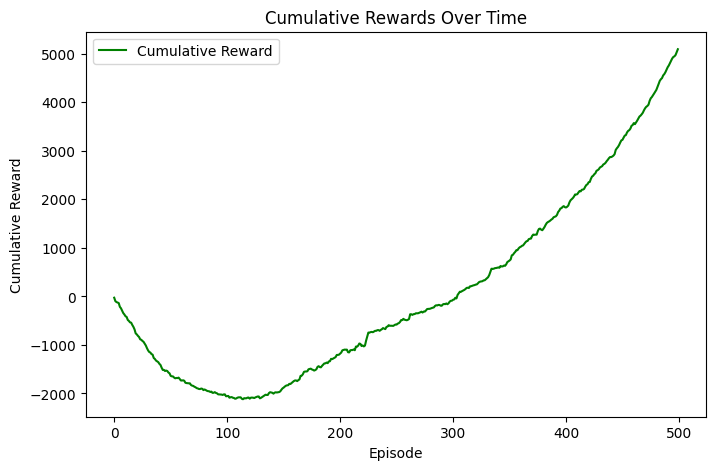

In [42]:
cumulative_rewards = np.cumsum(episode_rewards)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_rewards, label='Cumulative Reward', color='green')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Rewards Over Time')
plt.legend()
plt.show()

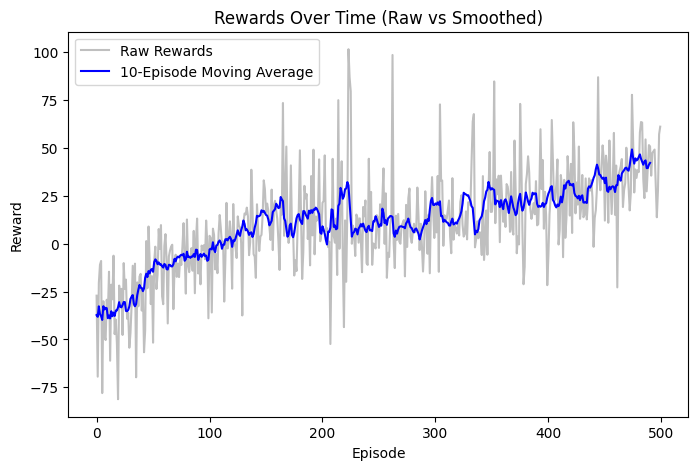

In [43]:
window_size = 10
smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')

# Plot raw and smoothed rewards
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards, label='Raw Rewards', alpha=0.5, color='gray')
plt.plot(smoothed_rewards, label=f'{window_size}-Episode Moving Average', color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Over Time (Raw vs Smoothed)')
plt.legend()
plt.show()

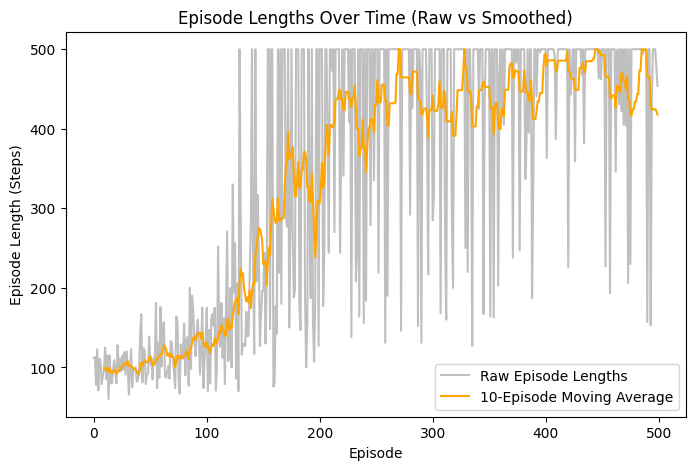

In [44]:
window_size = 10
smoothed_lengths = np.convolve(episode_lengths, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(8, 5))
plt.plot(episode_lengths, label='Raw Episode Lengths', alpha=0.5, color='gray')
plt.plot(range(window_size-1, len(episode_lengths)), smoothed_lengths, label=f'{window_size}-Episode Moving Average', color='orange')
plt.xlabel('Episode')
plt.ylabel('Episode Length (Steps)')
plt.title('Episode Lengths Over Time (Raw vs Smoothed)')
plt.legend()
plt.show()

In [29]:
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32)
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        q_values = dqn(state.unsqueeze(0))
        action = torch.argmax(q_values).item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    state = torch.tensor(next_state, dtype=torch.float32)
    done = terminated or truncated

print(f"Test Episode Reward: {total_reward:.2f}")

Test Episode Reward: 206.05


In [31]:
!pip install ipython

In [34]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import os

video_folder = './videos'
os.makedirs(video_folder, exist_ok=True)

env = gym.make('LunarLander-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)  

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32)
done = False

while not done:
    with torch.no_grad():
        q_values = dqn(state.unsqueeze(0))  
        action = torch.argmax(q_values).item()  
    next_state, reward, terminated, truncated, _ = env.step(action)  
    state = torch.tensor(next_state, dtype=torch.float32)  
    done = terminated or truncated  

env.close()

video_path = './videos/rl-video-episode-0.mp4'  
if os.path.exists(video_path):
    print("Success")
    display(Video(video_path, embed=True)) 
else:
    print("Error")

Success


In [39]:
import os

video_path = './videos/rl-video-episode-0.mp4'
if os.path.exists(video_path):
    print("The file exists.")
else:
    print("The file does not exist. Check the path.")

The file exists.


In [40]:
from IPython.display import FileLink
import os

absolute_video_path = os.path.abspath(video_path)

if os.path.exists(absolute_video_path):
    print("Video file found. You can download it below:")
    display(FileLink(absolute_video_path))
else:
    print("Video file not found. Please check the path.")

Video file found. You can download it below:


C:\Users\8778t\Natural Language Processing\videos\rl-video-episode-0.mp4